In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline

## Pré-tratamento dos dados

#### Pandas

In [4]:
df = pd.read_csv('SN_y_tot_V2.0.csv', sep=';', header=None)
# df.columns = ['year', 'month', 'FracDate', 'Sunspots', 'Std', 'Observations', 'Verified']
# df = df[['year', 'month', 'Sunspots']]

# #df['Date'] = pd.to_datetime(df["Date"])
# #df_idx = df.set_index(["Date"], drop=True)
# df['Date'] = df.apply(lambda row: datetime(
#                               int(row['year']), int(row['month']),1), axis=1)
# df['Date'] = pd.to_datetime(df["Date"])
# df_idx = df.set_index(["Date"], drop=True)
# df_idx.head(5)
df.tail()

,0,1,2,3,4
313,2013.5,94.0,6.9,5347,1
314,2014.5,113.3,8.0,5273,1
315,2015.5,69.8,6.4,8903,1
316,2016.5,39.8,3.9,9940,1
317,2017.5,21.7,2.5,11444,1


#### Ordenar os dados

In [10]:
df_idx = df_idx.sort_index(axis=1, ascending=True)
df_idx = df_idx.iloc[::-1]
df_idx.head(10)

,Sunspots,month,year
Date,,,
1749-01-01,96.7,1,1749
1749-02-01,104.3,2,1749
1749-03-01,116.7,3,1749
1749-04-01,92.8,4,1749
1749-05-01,141.7,5,1749
1749-06-01,139.2,6,1749
1749-07-01,158.0,7,1749
1749-08-01,110.5,8,1749
1749-09-01,126.5,9,1749


#### Plotagem dos dados

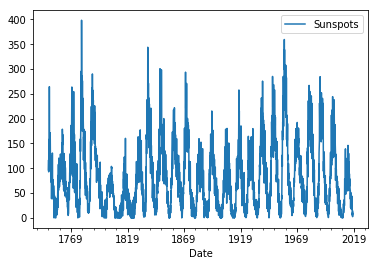

In [11]:
data = df_idx[['Sunspots']]
data.plot(y='Sunspots')
plt.show()

In [12]:
diff = data.index.values[-1] - data.index.values[0]
days = diff.astype('timedelta64[D]')
days = days / np.timedelta64(1, 'D')
years = int(days/365)
print("Total data: %d years"%years)
print("80 percent data = 1749 to %d"%(1749 + int(0.8*years)))

Total data: 269 years
80 percent data = 1749 to 1964


#### Dados de treino e validação

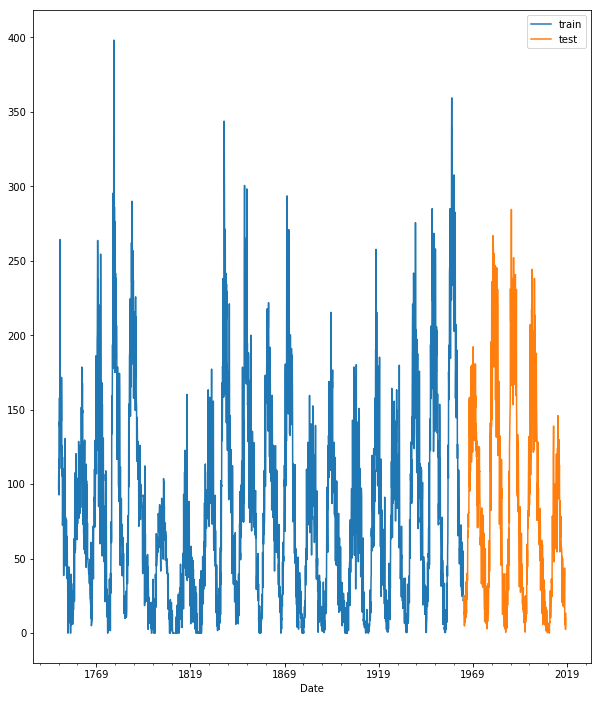

In [13]:
split_date = pd.Timestamp('01-01-1964')

train = data.loc[:split_date]
test = data.loc[split_date:]

ax = train.plot(figsize=(10,12))
test.plot(ax=ax)
plt.legend(['train', 'test'])
plt.show()

In [30]:
train.head()

,Sunspots
Date,
1749-01-01,96.7
1749-02-01,104.3
1749-03-01,116.7
1749-04-01,92.8
1749-05-01,141.7


#### Normalização

In [15]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
train_sc = sc.fit_transform(train)
test_sc = sc.transform(test)

In [16]:
train_sc_df = pd.DataFrame(train_sc, columns=['Y'], index=train.index)
test_sc_df = pd.DataFrame(test_sc, columns=['Y'], index=test.index)

for s in range(1,2):
    train_sc_df['X_{}'.format(s)] = train_sc_df['Y'].shift(s)
    test_sc_df['X_{}'.format(s)] = test_sc_df['Y'].shift(s)

X_train = train_sc_df.dropna().drop('Y', axis=1)
y_train = train_sc_df.dropna().drop('X_1', axis=1)

X_test = test_sc_df.dropna().drop('Y', axis=1)
y_test = test_sc_df.dropna().drop('X_1', axis=1)

X_train = X_train.as_matrix()
y_train = y_train.as_matrix()

X_test = X_test.as_matrix()
y_test = y_test.as_matrix()

In [17]:
print('Train size: (%d x %d)'%(X_train.shape[0], X_train.shape[1]))
print('Test size: (%d x %d)'%(X_test.shape[0], X_test.shape[1]))

Train size: (2580 x 1)
Test size: (652 x 1)


## Modelo SVM regressivo

In [18]:
from sklearn.svm import SVR
regressor = SVR(kernel='rbf')

In [19]:
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

/home/janarf/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


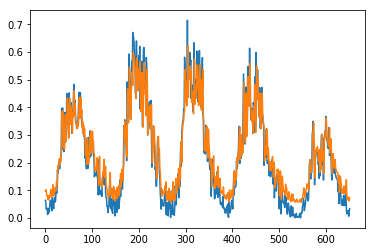

In [20]:
plt.plot(y_test)
plt.plot(y_pred)

In [21]:
from sklearn.metrics import r2_score

def adj_r2_score(r2, n, k):
    return 1-((1-r2)*((n-1)/(n-k-1)))

r2_test = r2_score(y_test, y_pred)
print("R-squared is: %f"%r2_test)

R-squared is: 0.854259


## Usando Redes Neurais

In [22]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
import keras.backend as K

Using TensorFlow backend.


### 1 hidden layer with 1 neuron

In [26]:
K.clear_session()
model = Sequential()
model.add(Dense(1, input_shape=(X_test.shape[1],), activation='tanh', kernel_initializer='lecun_uniform'))
model.compile(optimizer=Adam(lr=0.001), loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=16, epochs=10, verbose=1)

Epoch 1/10
2580/2580 [==============================] - 0s 59us/step - loss: 0.0084
Epoch 2/10
2580/2580 [==============================] - 0s 50us/step - loss: 0.0063
Epoch 3/10
2580/2580 [==============================] - 0s 53us/step - loss: 0.0057
Epoch 4/10
2580/2580 [==============================] - 0s 52us/step - loss: 0.0052
Epoch 5/10
2580/2580 [==============================] - 0s 53us/step - loss: 0.0050
Epoch 6/10
2580/2580 [==============================] - 0s 46us/step - loss: 0.0049
Epoch 7/10
2580/2580 [==============================] - 0s 51us/step - loss: 0.0048
Epoch 8/10
2580/2580 [==============================] - 0s 52us/step - loss: 0.0047
Epoch 9/10
2580/2580 [==============================] - 0s 49us/step - loss: 0.0047
Epoch 10/10
2580/2580 [==============================] - 0s 52us/step - loss: 0.0047


R-Squared: 0.871484


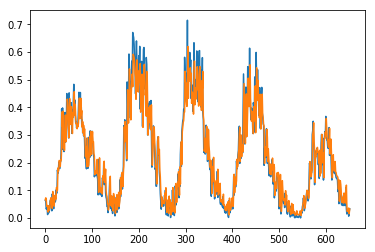

In [27]:
y_pred = model.predict(X_test)
plt.plot(y_test)
plt.plot(y_pred)
print('R-Squared: %f'%(r2_score(y_test, y_pred)))

#### 2 Hidden Layers with 50 neurons each and ReLU activation function

In [28]:
K.clear_session()
model = Sequential()
model.add(Dense(50, input_shape=(X_test.shape[1],), activation='relu', kernel_initializer='lecun_uniform'))
model.add(Dense(50, input_shape=(X_test.shape[1],), activation='relu'))
model.add(Dense(1))
model.compile(optimizer=Adam(lr=0.001), loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=16, epochs=20, verbose=1)

Epoch 1/20
2580/2580 [==============================] - 0s 78us/step - loss: 0.0123
Epoch 2/20
2580/2580 [==============================] - 0s 58us/step - loss: 0.0050
Epoch 3/20
2580/2580 [==============================] - 0s 58us/step - loss: 0.0049
Epoch 4/20
2580/2580 [==============================] - 0s 60us/step - loss: 0.0049
Epoch 5/20
2580/2580 [==============================] - 0s 45us/step - loss: 0.0049
Epoch 6/20
2580/2580 [==============================] - 0s 46us/step - loss: 0.0049
Epoch 7/20
2580/2580 [==============================] - 0s 47us/step - loss: 0.0049
Epoch 8/20
2580/2580 [==============================] - 0s 62us/step - loss: 0.0049
Epoch 9/20
2580/2580 [==============================] - 0s 76us/step - loss: 0.0050
Epoch 10/20
2580/2580 [==============================] - 0s 96us/step - loss: 0.0049
Epoch 11/20
2580/2580 [==============================] - 0s 69us/step - loss: 0.0050
Epoch 12/20
2580/2580 [==============================] - 0s 59us/step - lo

R-Squared: 0.870969


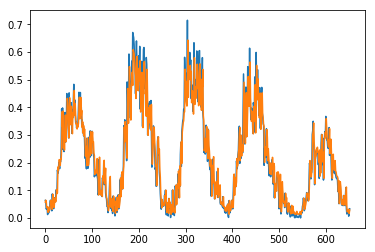

In [29]:
y_pred = model.predict(X_test)
plt.plot(y_test)
plt.plot(y_pred)
print('R-Squared: %f'%(r2_score(y_test, y_pred)))